#Dark Channel Prior (DCP) Processing #

Total image: 753
Processing: 100.png
Processing: 1000.png
Processing: 1001.png
Processing: 101.png
Processing: 102.png
Processing: 103.png
Processing: 104.png
Processing: 105.png
Processing: 106.png
Processing: 107.png
Processing: 108.png
Processing: 109.png
Processing: 111.png
Processing: 112.png
Processing: 113.png
Processing: 114.png
Processing: 115.png
Processing: 116.png
Processing: 117.png
Processing: 118.png
Processing: 119.png
Processing: 120.png
Processing: 121.png
Processing: 122.png
Processing: 123.png
Processing: 124.png
Processing: 125.png
Processing: 126.png
Processing: 127.png
Processing: 128.png
Processing: 129.png
Processing: 130.png
Processing: 132.png
Processing: 133.png
Processing: 134.png
Processing: 135.png
Processing: 136.png
Processing: 138.png
Processing: 139.png
Processing: 140.png
Processing: 141.png
Processing: 142.png
Processing: 143.png
Processing: 144.png
Processing: 145.png
Processing: 147.png
Processing: 148.png
Processing: 149.png
Processing: 151.png
P

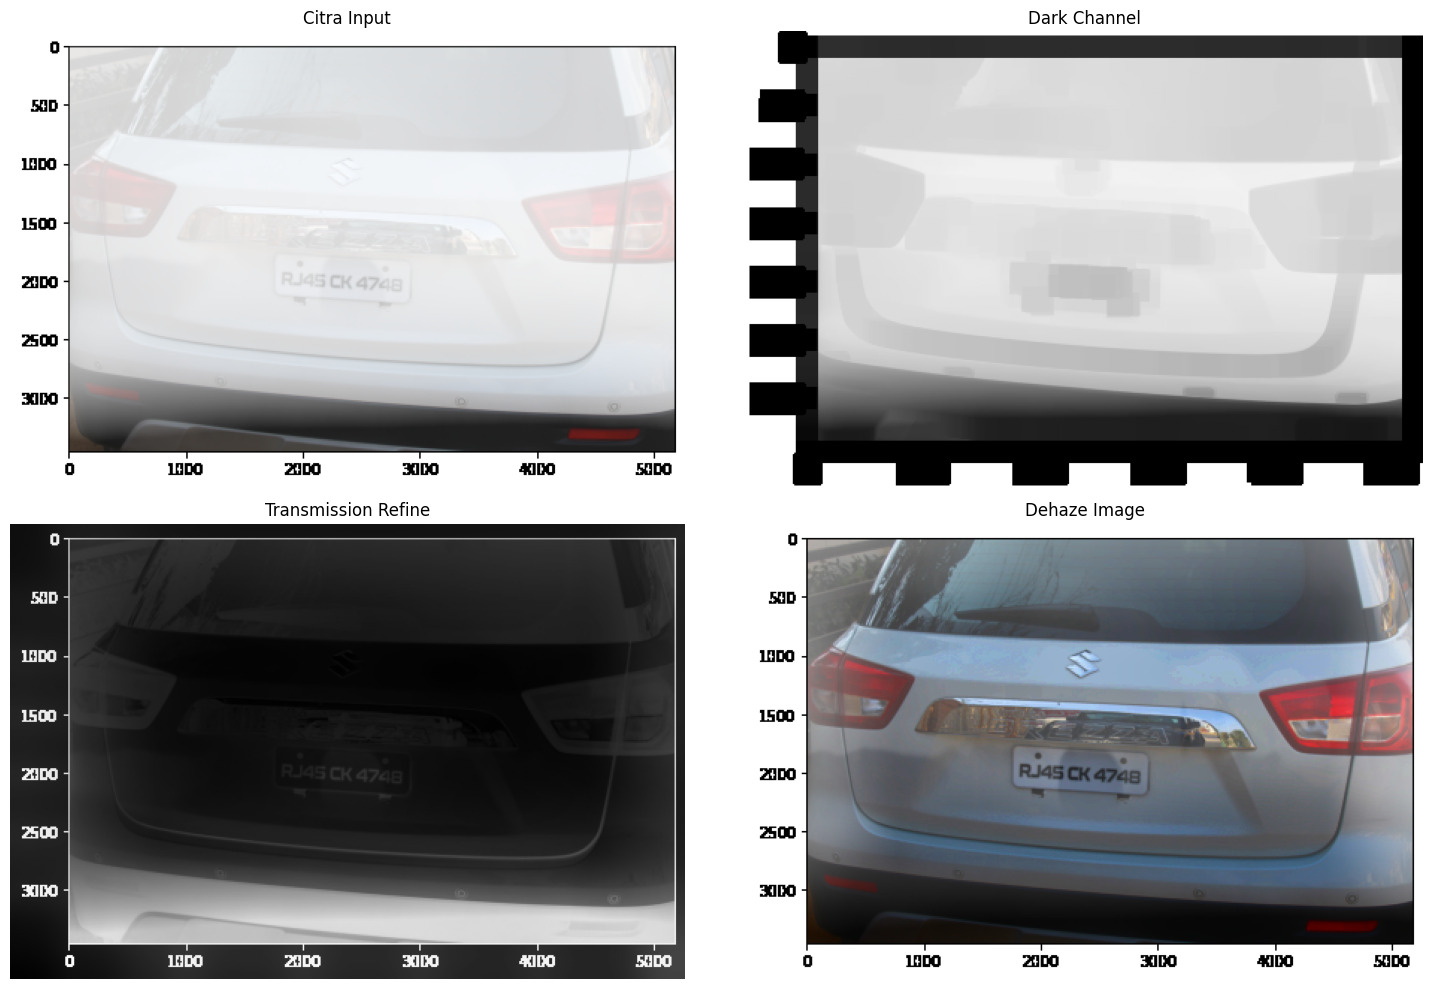

In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import os


def DarkChannel(im, sz):
    b, g, r = cv2.split(im)
    dc = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (sz, sz))
    dark = cv2.erode(dc, kernel)
    return dark

def AtmLight(im, dark):
    h, w = im.shape[:2]
    imsz = h * w
    numpx = int(max(math.floor(imsz / 1000), 1))
    darkvec = dark.reshape(imsz)
    imvec = im.reshape(imsz, 3)

    indices = darkvec.argsort()
    indices = indices[imsz - numpx :]

    atmsum = np.zeros([1, 3])
    for ind in range(1, numpx):
        atmsum += imvec[indices[ind]]

    A = atmsum / numpx
    return A

def TransmissionEstimate(im, A, sz):
    omega = 0.95
    im3 = np.empty(im.shape, im.dtype)
    for ind in range(3):
        im3[:, :, ind] = im[:, :, ind] / A[0, ind]

    transmission = 1 - omega * DarkChannel(im3, sz)
    return transmission

def Guidedfilter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    q = mean_a * im + mean_b
    return q

def TransmissionRefine(im, et):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray) / 255
    r = 60
    eps = 0.0001
    t = Guidedfilter(gray, et, r, eps)
    return t

def Recover(im, t, A, tx=0.1):
    res = np.empty(im.shape, im.dtype)
    t = cv2.max(t, tx)

    for ind in range(3):
        res[:, :, ind] = (im[:, :, ind] - A[0, ind]) / t + A[0, ind]
    return res


# ==========================================================
#  DEHAZE 1 FOLDER
# ==========================================================

input_folder = "haze_input"
output_folder = "Haze_output"

os.makedirs(output_folder, exist_ok=True)

files = sorted([f for f in os.listdir(input_folder) if f.lower().endswith(('.png','.jpg','.jpeg'))])

print("Total image:", len(files))

# simpan contoh untuk ditampilkan
sample_src2 = None
sample_dark = None
sample_t = None
sample_haze2 = None

for idx, filename in enumerate(files):
    path = os.path.join(input_folder, filename)

    print("Processing:", filename)

    src = cv2.imread(path)
    src2 = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    I = src.astype('float64') / 255

    dark = DarkChannel(I, 15)
    A = AtmLight(I, dark)
    te = TransmissionEstimate(I, A, 5)
    t = TransmissionRefine(src, te)
    J = Recover(I, t, A, 0.1)

    outname = os.path.join(output_folder, filename)
    cv2.imwrite(outname, J * 255)

    # Simpan 2 gambar pertama untuk ditampilkan
    if idx == 0:
        sample_src2 = src2
        sample_dark = dark
        sample_t = t
        haze = cv2.imread(outname)
        sample_haze2 = cv2.cvtColor(haze, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(2,2,1)
ax1.set_title("Citra Input")
ax1.imshow(sample_src2)
ax1.axis("off")

ax2 = fig.add_subplot(2,2,2)
ax2.set_title("Dark Channel")
ax2.imshow(sample_dark, cmap="gray")
ax2.axis("off")

ax3 = fig.add_subplot(2,2,3)
ax3.set_title("Transmission Refine")
ax3.imshow(sample_t, cmap="gray")
ax3.axis("off")

ax4 = fig.add_subplot(2,2,4)
ax4.set_title("Dehaze Image")
ax4.imshow(sample_haze2)
ax4.axis("off")

plt.tight_layout()
plt.show()


#YOLOv11 Crop

In [8]:
from ultralytics import YOLO
import cv2
import os

# ============================
# 1. Load model
# ============================
model = YOLO("best_yolov11.pt")

# ============================
# 2. Folder input dan output
# ============================
input_folder = "haze_output"
output_folder = "crop_results"
os.makedirs(output_folder, exist_ok=True)

# ============================
# 3. Proses semua gambar
# ============================
for img_name in os.listdir(input_folder):

    if img_name.lower().endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(input_folder, img_name)
        img = cv2.imread(img_path)

        print("Processing:", img_name)

        results = model(img)[0]

        # Ambil hanya box pertama
        if len(results.boxes.xyxy) > 0:
            box = results.boxes.xyxy[0]
            x1, y1, x2, y2 = map(int, box)

            crop = img[y1:y2, x1:x2]

            # Simpan dengan nama asli
            cv2.imwrite(os.path.join(output_folder, img_name), crop)

print("Finish:", output_folder)


Processing: 100.png

0: 448x640 1 Plat_Nomor, 166.1ms
Speed: 77.6ms preprocess, 166.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Processing: 1000.png

0: 448x640 1 Plat_Nomor, 150.3ms
Speed: 2.4ms preprocess, 150.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Processing: 1001.png

0: 448x640 1 Plat_Nomor, 139.8ms
Speed: 3.4ms preprocess, 139.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Processing: 101.png

0: 448x640 1 Plat_Nomor, 125.7ms
Speed: 4.4ms preprocess, 125.7ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)
Processing: 102.png

0: 448x640 1 Plat_Nomor, 142.5ms
Speed: 3.2ms preprocess, 142.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Processing: 103.png

0: 448x640 1 Plat_Nomor, 129.0ms
Speed: 3.0ms preprocess, 129.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Processing: 104.png

0: 448x640 1 Plat_Nomor, 125.3ms
Speed: 4.5ms preprocess, 125.3m